In [3]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Download required NLTK data
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Load dictionary and test data
dictionary_path = 'Dictionary 10.xlsx'
test_data_path = 'TEST DATA.csv'

# Read dictionary from excel file
dictionary_df = pd.read_excel(dictionary_path)

# Read test data from csv file
test_data_df = pd.read_csv(test_data_path)

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocess text: lowercase, remove stopwords, lemmatize, and POS tag
def preprocess(text):
    # Tokenize words from the text
    words = word_tokenize(text.lower())
    
    # Lemmatize words and remove stopwords, keep only alphanumeric tokens
    words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words]
    
    # Apply POS tagging
    pos_words = pos_tag(words)
    
    # Keep only nouns (NN), adjectives (JJ), and verbs (VB)
    allowed_pos = {'NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}
    filtered_words = [word for word, pos in pos_words if pos in allowed_pos]
    
    # Return processed sentence as a string
    return ' '.join(filtered_words)

# Preprocess dictionary words
dictionary_df = dictionary_df.applymap(lambda x: preprocess(x) if isinstance(x, str) else x)

# Preprocess test data sentences
test_data_df['Text'] = test_data_df['Text'].astype(str).apply(preprocess)

# Aggregate text by Text-ID (combine multiple sentences into one for each Text-ID)
aggregated_text_df = test_data_df.groupby('Text-ID')['Text'].apply(' '.join).reset_index()

# Initialize result_counts dataframe with the necessary columns
behavior_columns = ["Security", "Conformity", "Tradition", "Benevolence", "Universalism",
                    "Self-Direction", "Stimulation", "Hedonism", "Achievement", "Power"]
result_counts = pd.DataFrame(columns=['Text-ID'] + behavior_columns)
result_counts['Text-ID'] = aggregated_text_df['Text-ID']
result_counts = result_counts.fillna(0)

# Function to count matches
def count_matches(sentence, words_list):
    sentence_words = set(sentence.split())
    return sum(word in sentence_words for word in words_list)

# Count matches for each behavior category in aggregated text
for idx, row in aggregated_text_df.iterrows():
    sentence = row['Text']  # Preprocessed and aggregated text for the Text-ID
    for column in behavior_columns:
        # Get the list of words for the corresponding behavior category
        words_list = dictionary_df[column].dropna().tolist()
        result_counts.at[idx, column] = count_matches(sentence, words_list)

# Create binary_counts dataframe with the same structure as result_counts
binary_counts = result_counts.copy()

# Initialize all count columns to 0 for binary
binary_counts[behavior_columns] = 0

# Iterate over each row to set the highest value to 1 in the binary_counts
for idx, row in result_counts.iterrows():
    highest_category = row[1:].idxmax()  # Find the column with the highest count
    if result_counts.loc[idx, highest_category] > 0:
        binary_counts.at[idx, highest_category] = 1

# Save the result_counts (Word Counts) to an Excel file
output_path_counts = 'POS_Word_Counts.xlsx'
result_counts.to_excel(output_path_counts, index=False, sheet_name='Counts')

# Save the binary_counts (Binary representation) to an Excel file
output_path_binary = 'POS_Word_Binary.xlsx'
binary_counts.to_excel(output_path_binary, index=False, sheet_name='Binary')

print("Files have been saved successfully.")


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rites\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rites\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rites\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rites\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
C:\Users\rites\AppData\Local\Temp\ipykernel_29208\740194638.py:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dictionary_df = dictionary_df.applymap(lambda x: preprocess(x) if isinstance(x, str) else x)


Files have been saved successfully.


In [4]:
import pandas as pd

# Load the provided Excel files
expert_binary_path = 'Expert_binary.xlsx'
word_binary_path = 'POS_Word_Binary.xlsx'

expert_binary = pd.read_excel(expert_binary_path)
word_binary = pd.read_excel(word_binary_path)

# Merge the two dataframes on 'Text-ID'
merged_df = pd.merge(expert_binary, word_binary, on='Text-ID', suffixes=('_expert', '_word'))

# Create new columns
merged_df['Expert Category'] = merged_df.filter(regex='_expert$').idxmax(axis=1).str.replace('_expert', '')
merged_df['Word Category'] = merged_df.filter(regex='_word$').idxmax(axis=1).str.replace('_word', '')
merged_df['Match'] = merged_df['Expert Category'] == merged_df['Word Category']

# Adjust the calculation of match percentage to compare categories rather than words
def calculate_category_match_percentage(expert_category, word_category):
    return 100.0 if expert_category == word_category else 0.0

# Calculate Expert Match % and Word Match %
merged_df['Expert Match %'] = merged_df.apply(lambda row: calculate_category_match_percentage(row['Expert Category'], row['Word Category']), axis=1)
merged_df['Word Match %'] = merged_df.apply(lambda row: calculate_category_match_percentage(row['Word Category'], row['Expert Category']), axis=1)

# Select required columns with correct suffixes
expert_columns = [col for col in merged_df.columns if col.endswith('_expert')]
word_columns = [col for col in merged_df.columns if col.endswith('_word')]
category_columns = [col.replace('_expert', '') for col in expert_columns]

# Prepare the final dataframe
final_df = merged_df[['Text-ID'] + expert_columns + word_columns + ['Expert Category', 'Word Category', 'Match', 'Expert Match %', 'Word Match %']]

# Rename the columns for clarity
final_df.columns = ['Text-ID'] + [f'Expert_{col.replace("_expert", "")}' for col in expert_columns] + \
                   [f'Word_{col.replace("_word", "")}' for col in word_columns] + \
                   ['Expert Category', 'Word Category', 'Match', 'Expert Match %', 'Word Match %']

# Save the final dataframe to a new Excel file
output_path_final = 'Final_POS_Output.xlsx'
final_df.to_excel(output_path_final, index=False)

print(f"Final output saved to {output_path_final}")


Final output saved to Final_POS_Output.xlsx


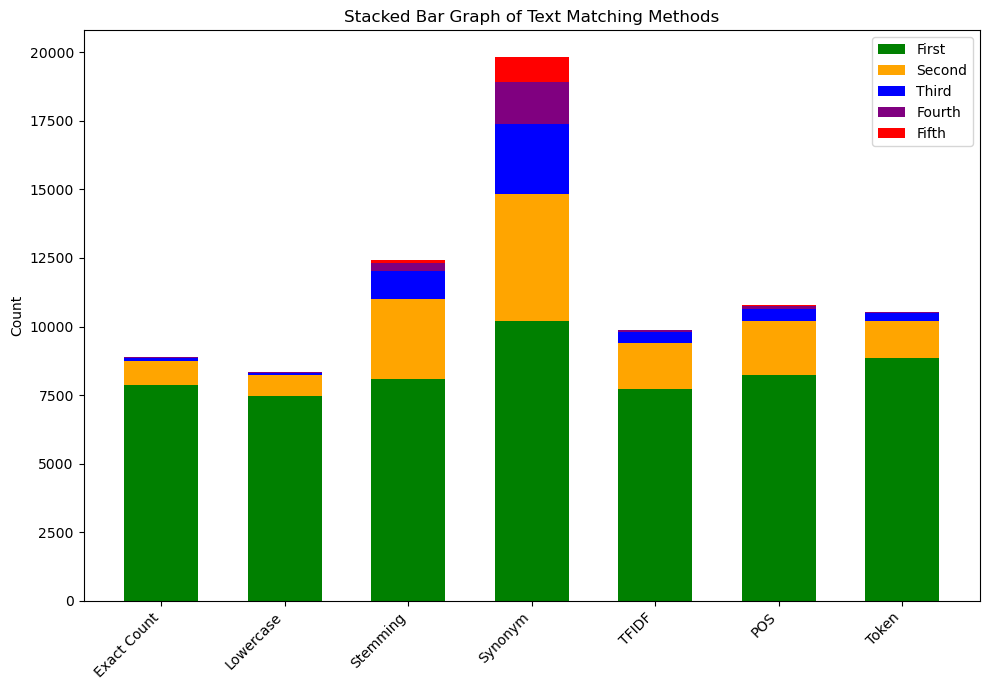

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Data as provided
categories = ['Exact Count', 'Lowercase', 'Stemming', 'Synonym', 'TFIDF', 'POS', 'Token']

data = {
    'Category': categories,
    'First': [7861, 7468, 8086, 10185, 7713, 8232, 8845],
    'Second': [879, 753, 2936, 4652, 1685, 1962, 1372],
    'Third': [117, 100, 1017, 2536, 390, 451, 270],
    'Fourth': [14, 11, 294, 1559, 73, 110, 47],
    'Fifth': [5, 4, 80, 881, 11, 19, 10]
}

# Convert to numpy arrays for plotting
first = np.array(data['First'])
second = np.array(data['Second'])
third = np.array(data['Third'])
fourth = np.array(data['Fourth'])
fifth = np.array(data['Fifth'])

# Set the figure size
plt.figure(figsize=(10, 7))

# Create a stacked bar chart
bar_width = 0.6
indices = np.arange(len(categories))

# Plot each stack
plt.bar(indices, first, color='green', label='First', width=bar_width)
plt.bar(indices, second, bottom=first, color='orange', label='Second', width=bar_width)
plt.bar(indices, third, bottom=first+second, color='blue', label='Third', width=bar_width)
plt.bar(indices, fourth, bottom=first+second+third, color='purple', label='Fourth', width=bar_width)
plt.bar(indices, fifth, bottom=first+second+third+fourth, color='red', label='Fifth', width=bar_width)

# Add category labels to the x-axis
plt.xticks(indices, categories, rotation=45, ha='right')

# Add labels and title
plt.ylabel('Count')
plt.title('Stacked Bar Graph of Text Matching Methods')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()
